<div style="background-color: #FFDDDD; border-left: 5px solid red; padding: 10px; color: black;">
    <strong>Kernel: Python 3 (ipykernel)
</div>

# Fine-tune your RAFT model with PyTorch FSDP and Q-Lora on Amazon SageMaker

This blog post explains how you can fine-tune a Llama 3.1 8b model using PyTorch FSDP and Q-Lora with the help of Hugging Face [TRL](https://huggingface.co/docs/trl/index), [Transformers](https://huggingface.co/docs/transformers/index), [peft](https://huggingface.co/docs/peft/index) & [datasets](https://huggingface.co/docs/datasets/index) on Amazon SageMaker. 

**FSDP + Q-Lora Background**

Hugging Face share the support of Q-Lora and PyTorch FSDP (Fully Sharded Data Parallel). FSDP and Q-Lora allows you now to fine-tune Llama-like architectures or Mixtral 8x7B. Hugging Face PEFT is were the core logic resides, read more about it in the [PEFT documentation](https://huggingface.co/docs/peft/v0.10.0/en/accelerate/fsdp).

* [PyTorch FSDP](https://pytorch.org/blog/introducing-pytorch-fully-sharded-data-parallel-api/) is a data/model parallelism technique that shards model across GPUs, reducing memory requirements and enabling the training of larger models more efficiently​​​​​​.
* Q-LoRA is a fine-tuning method that leverages quantization and Low-Rank Adapters to efficiently reduced computational requirements and memory footprint. 

This blog post walks you thorugh how to fine-tune open LLMs from Hugging Face using Amazon SageMaker.

## 1. Setup Development Environment

Our first step is to install Hugging Face Libraries we need on the client to correctly prepare our dataset and start our training/evaluations jobs. Ignore this line if you've already run task 1

In [99]:
%pip install -Uq py7zr==0.22.0
%pip install -Uq datasets==2.21.0
%pip install -Uq transformers==4.45.0
%pip install -Uq peft==0.12.0
%pip install -Uq s3fs==2024.9.0

Note: you may need to restart the kernel to use updated packages.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-ai 2.29.1 requires faiss-cpu!=1.8.0.post0,<2.0.0,>=1.8.0, which is not installed.
dask 2025.2.0 requires cloudpickle>=3.0.0, but you have cloudpickle 2.2.1 which is incompatible.
distributed 2025.2.0 requires cloudpickle>=3.0.0, but you have cloudpickle 2.2.1 which is incompatible.
s3fs 2024.9.0 requires fsspec==2024.9.0.*, but you have fsspec 2024.6.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.


If you are going to use Sagemaker in your own environment, you need access to an IAM Role with the required permissions for Sagemaker. You can learn more about it [here](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html).



In [64]:
import sagemaker
import boto3
from datasets import load_dataset
from sagemaker.pytorch import PyTorch
import matplotlib.pyplot as plt
from sagemaker.s3 import S3Downloader
import os
from sagemaker.model import Model


sess = sagemaker.Session()
sagemaker_session_bucket=None

if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

sagemaker role arn: arn:aws:iam::340043819279:role/service-role/AmazonSageMaker-ExecutionRole-20210628T084457
sagemaker bucket: sagemaker-us-west-2-340043819279
sagemaker session region: us-west-2


In [65]:
#This parameter will toggle between local mode (downloading from S3) and loading models from the HF Model Hub.
#In a workshop environment you will have a local model pre-downloaded. 
#Otherwise you will either download the model to S3 and leave this True, or set this to false and fill in the HuggingFace Model ID and Token if necessary.
USE_LOCAL_MODEL_FROM_S3 = True


if USE_LOCAL_MODEL_FROM_S3 == True:
    os.environ['use_local']="true"
    #the default path set here is for workshop environments. 
    #If using this outside of a hosted workshop, you will need to set this to wherever you downloaded your model.
    #Ignore the model_id and hf_token fields, they are simply being cleared here to avoid conflicts with subsequent runs.
    os.environ['model_id']=""
    os.environ['hf_token']=""
    os.environ['base_model_s3_path']=f""

else:
    os.environ['use_local']="false"
    # Model_ID - set this to the HuggingFace Model ID you want to load.
    os.environ['model_id']="meta-llama/Meta-Llama-3.1-8B-Instruct"    
    # HF_Token - use your HuggingFace Token here to access gated models. Llama-3-8B-Instruct is a gated model.
    os.environ['hf_token']="<<YOUR_HF_TOKEN>>"
    #ignore this env variable for remote mode
    os.environ['base_model_s3_path']=""

In [66]:
# Uncomment this variable and set the value to your MLFlow Tracking Server ARN to activate MLFLow experiment tracking
os.environ['mlflow_tracking_server_arn']="<<YOUR_MLFLOW_TRACKING_SERVER_ARN>>"

## 2. Create and prepare the dataset

For training your model, you will use the `CONTEXT` property rather that the `ORACLE` property. This will introduce distractor documents into the training process to allow the model to better discern the signal from noise.

Here you'll generate the training prompts with the `CONTEXT` as well as the synthetically generated `ANSWER` from the dataset generation. We will hold out a subset for validation and testing.

In [67]:
# Convert dataset to summarization messages  
def create_rag_sft_prompts(data_point):
    full_prompt = f"""
        <|begin_of_text|>
        <|start_header_id|>system<|end_header_id|>
        You are an assistant for question-answering tasks. Answer the following question in 5 sentences using the provided context. If you don't know the answer, just say "I don't know.".
        <|start_header_id|>user<|end_header_id|>
        Context: {data_point["context"]}
        
        Question: {data_point["question"]}
        <|start_header_id|>assistant<|end_header_id|> 
        Answer:{data_point["synthetic_answer"]}"""
    return {"prompt": full_prompt}



Here you will load your synthetic dataset, then generate your train/test/validation splits. 

In this example, you'll take 80% of the data for training, then 20% for training/validation, then split the 20% in half to give 10% validation and 10% test splits and reassemble into a single dataset object.

In [68]:
from datasets import DatasetDict
full_dataset = load_dataset("json", data_files="./data/synthetic_data/synthetic_training_data.json", split="train")

columns_to_remove = list(full_dataset.features)

train_test_eval_dataset = full_dataset.train_test_split(test_size=0.2, shuffle=True)
test_eval_dataset = train_test_eval_dataset['test'].train_test_split(test_size=0.5)

full_dataset = DatasetDict({
    'train': train_test_eval_dataset['train'].map(
        create_rag_sft_prompts,
        remove_columns=columns_to_remove,
        batched=False
    ),
    'eval': test_eval_dataset['train'].map(
        create_rag_sft_prompts,
        remove_columns=columns_to_remove,
        batched=False
    ),
    'test': test_eval_dataset['test'].map(
        create_rag_sft_prompts,
        batched=False
    )
})

# full_dataset = full_dataset.map(
#     create_rag_sft_prompts,
#     remove_columns=columns_to_remove,
#     batched=False
# )

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/32000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

In [69]:
# Review dataset
full_dataset, full_dataset['train'][0]

(DatasetDict({
     train: Dataset({
         features: ['prompt'],
         num_rows: 32000
     })
     eval: Dataset({
         features: ['prompt'],
         num_rows: 4000
     })
     test: Dataset({
         features: ['synthetic_answer', 'distracted', 'original_answer', 'question', 'context', 'oracle', 'prompt'],
         num_rows: 4000
     })
 }),
 {'prompt': '\n        <|begin_of_text|>\n        <|start_header_id|>system<|end_header_id|>\n        You are an assistant for question-answering tasks. Answer the following question in 5 sentences using the provided context. If you don\'t know the answer, just say "I don\'t know.".\n        <|start_header_id|>user<|end_header_id|>\n        Context: 21 severely affected acute stroke patients deemed at high risk for systemic infections (median (interquartile range (IQR)) at admission NIHSSS 19 (15-30) were enrolled; 20 patients were intubated within 5h after ICU admission. All patients developed clinical signs and laboratory constell

After we processed the datasets we are going to use the [FileSystem integration](https://huggingface.co/docs/datasets/filesystems) to upload our dataset to S3. We are using the `sess.default_bucket()`, adjust this if you want to store the dataset in a different S3 bucket. We will use the S3 path later in our training script.

In [70]:
# save train_dataset to s3 using our SageMaker session
local_data_path = "datasets/raft"
s3_data_path = f's3://{sess.default_bucket()}/datasets/raft'

# Save datasets to s3 and locally
# We will fine tune only with 20 records due to limited compute resource for the workshop
full_dataset["train"].to_json(f"{local_data_path}/train/train.json", orient="records")
full_dataset["train"].to_json(f"{s3_data_path}/train/train.json", orient="records")
train_dataset_s3_path = f"{s3_data_path}/train/train.json"

full_dataset["eval"].to_json(f"{local_data_path}/eval/eval.json", orient="records")
full_dataset["eval"].to_json(f"{s3_data_path}/eval/eval.json", orient="records")
eval_dataset_s3_path = f"{s3_data_path}/eval/eval.json"

full_dataset["test"].to_json(f"{local_data_path}/test/test.json", orient="records")
full_dataset["test"].to_json(f"{s3_data_path}/test/test.json", orient="records")
test_dataset_s3_path = f"{s3_data_path}/test/test.json"

print(f"Training data uploaded to:")
print(train_dataset_s3_path)
print(eval_dataset_s3_path)
print(test_dataset_s3_path)
print(f"\nYou can view the uploaded dataset in the console here: \nhttps://s3.console.aws.amazon.com/s3/buckets/{sess.default_bucket()}/?region={sess.boto_region_name}&prefix={s3_data_path.split('/', 3)[-1]}/")

Creating json from Arrow format:   0%|          | 0/32 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/32 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

Training data uploaded to:
s3://sagemaker-us-west-2-340043819279/datasets/raft/train/train.json
s3://sagemaker-us-west-2-340043819279/datasets/raft/eval/eval.json
s3://sagemaker-us-west-2-340043819279/datasets/raft/test/test.json

You can view the uploaded dataset in the console here: 
https://s3.console.aws.amazon.com/s3/buckets/sagemaker-us-west-2-340043819279/?region=us-west-2&prefix=datasets/raft/


### Measure input length

While passing in a dataset to the LLM for fine-tuning, it's important to ensure that the inputs are all of a uniform length. To achieve this, we first visualize the distribution of the input token lengths (or alternatively, firectly find the max length). Based on these results, we identify the maximum input token length, and utilize "padding" to ensure all the inputs are of the same length.

In [71]:
def plot_data_lengths(tokenized_train_dataset, tokenized_validation_dataset):
    lengths1 = [len(x["prompt"].split()) for x in tokenized_train_dataset]
    lengths2 = [len(x["prompt"].split()) for x in tokenized_validation_dataset]
    lengths = lengths1 + lengths2
    
    plt.figure(figsize=(10,6))
    plt.hist(lengths, bins=20, alpha=0.7, color="blue")
    plt.xlabel("prompt lengths")
    plt.ylabel("Frequency")
    plt.title("Distribution of lengths of input_ids")
    plt.show()

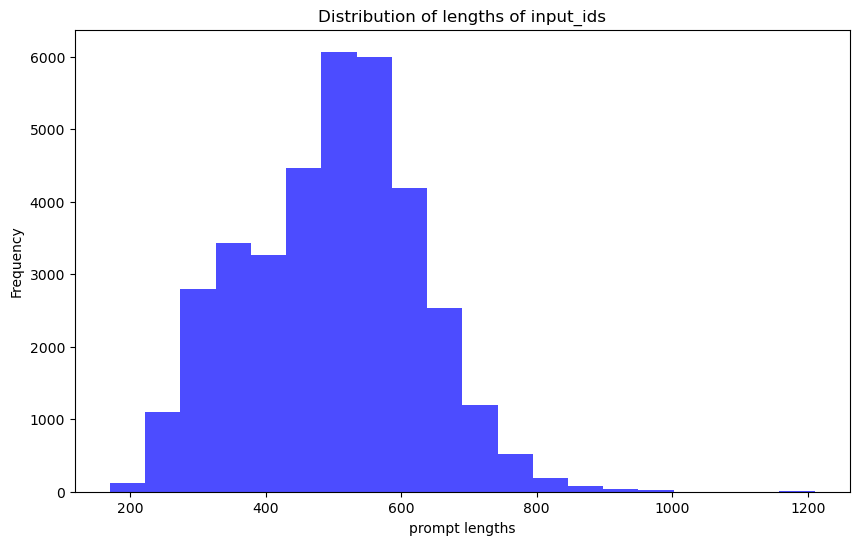

In [72]:
plot_data_lengths(full_dataset["train"], full_dataset["eval"])

## 3. Fine-tune Llama 3.1 on Amazon SageMaker

We are now ready to fine-tune our model. We will use the [SFTTrainer](https://huggingface.co/docs/trl/sft_trainer) from `trl` to fine-tune our model. The `SFTTrainer` makes it straightfoward to supervise fine-tune open LLMs. The `SFTTrainer` is a subclass of the `Trainer` from the `transformers`. We prepared a script [launch_fsdp_qlora.py](scripts/launch_fsdp_qlora.py) which will loads the dataset from disk, prepares the model/tokenizer, and starts the training. It usees the [SFTTrainer](https://huggingface.co/docs/trl/sft_trainer) from `trl` to fine-tune our model. 

For configuration we use `TrlParser`, that allows us to provide hyperparameters in a yaml file. This `yaml` will be uploaded and provided to Amazon SageMaker similar to our datasets. Below is the config file for fine-tuning your model. You will save the config file as `args.yaml` and upload it to S3 to be used in your training job.


In [73]:
%%bash

cat > ./args.yaml <<EOF
hf_token: "${hf_token}"                         # Use HF token to login into Hugging Face to access the Llama 3.1 8b model
model_id: "${model_id}"                         # Hugging Face model id
use_local: "${use_local}"

max_seq_length: 2048  #512 # 2048               # max sequence length for model and packing of the dataset
# sagemaker specific parameters
train_dataset_path: "/opt/ml/input/data/train/" # path to where SageMaker saves train dataset
eval_dataset_path: "/opt/ml/input/data/eval/"   # path to where SageMaker saves eval dataset
base_model_s3_path: "/opt/ml/input/data/basemodel/"
#tokenizer_s3_path: "/opt/ml/input/data/tokenizer/"
ml_tracking_server_arn: "${mlflow_tracking_server_arn}"

output_dir: "/opt/ml/model/llama3.1/adapters/sum"         # path to where SageMaker will upload the model 
# training parameters
report_to: "mlflow"                    # report metrics to tensorboard
learning_rate: 0.0002                  # learning rate 2e-4
lr_scheduler_type: "constant"          # learning rate scheduler
num_train_epochs: 5                    # number of training epochs
per_device_train_batch_size: 8         # batch size per device during training
per_device_eval_batch_size: 4          # batch size for evaluation
gradient_accumulation_steps: 1         # number of steps before performing a backward/update pass
optim: adamw_torch                     # use torch adamw optimizer
logging_steps: 10                      # log every 10 steps
save_strategy: epoch                   # save checkpoint every epoch
eval_strategy: epoch                   # evaluate every epoch
max_grad_norm: 0.3                     # max gradient norm
warmup_ratio: 0.03                     # warmup ratio
bf16: false                            # use bfloat16 precision
tf32: false                            # use tf32 precision
fp16: true
# FSDP parameters: https://huggingface.co/docs/transformers/main/en/fsdp
fsdp: "full_shard auto_wrap offload"   # remove offload if enough GPU memory
fsdp_config:
    backward_prefetch: "backward_pre"
    forward_prefetch: "false"
    use_orig_params: "false"
    activation_checkpointing: true

EOF

Now upload the config file to S3. 

In [74]:
from sagemaker.s3 import S3Uploader

# upload the model yaml file to s3
model_yaml = "args.yaml"
train_config_s3_path = S3Uploader.upload(local_path=model_yaml, desired_s3_uri=f"{s3_data_path}/config")

print(f"Training config uploaded to:")
print(train_config_s3_path)

Training config uploaded to:
s3://sagemaker-us-west-2-340043819279/datasets/raft/config/args.yaml


# Fine-tune LoRA adapter

Below estimtor will train the model with QLoRA and will save the LoRA adapter in S3 

In [75]:
# Create SageMaker PyTorch Estimator

# define Training Job Name 
job_name = f'llama3-1-8b-finetune'

pytorch_estimator = PyTorch(
    entry_point= 'launch_fsdp_qlora.py',
    source_dir="./scripts",
    job_name=job_name,
    base_job_name=job_name,
    max_run=50000,
    role=role,
    framework_version="2.2.0",
    py_version="py310",
    instance_count=1,
    #instance_type="ml.g5.12xlarge",
    #instance_type="ml.g6e.12xlarge",
    instance_type="ml.p4d.24xlarge",
    sagemaker_session=sess,
    volume_size=50,
    disable_output_compression=True,
    keep_alive_period_in_seconds=1800,
    distribution={"torch_distributed": {"enabled": True}},
    hyperparameters={
        "config": "/opt/ml/input/data/config/args.yaml" # path to TRL config which was uploaded to s3
    }
)

> Note: When using QLoRA, we only train adapters and not the full model. The [launch_fsdp_qlora.py](../scripts/fsdp/run_fsdp_qlora.py) saves the `adapter` at the end of the training to Amazon SageMaker S3 bucket (sagemaker-<region name>-<account_id>).

We can now start our training job, with the `.fit()` method passing our S3 path to the training script.

In [76]:
# define a data input dictonary with our uploaded s3 uris
data = {
  'train': train_dataset_s3_path,
  'eval': eval_dataset_s3_path,
  'config': train_config_s3_path
  }

if(os.environ["use_local"].lower()=="true"):
    data.update({'basemodel':os.environ['base_model_s3_path']})
 
# Check input channels configured 
data

{'train': 's3://sagemaker-us-west-2-340043819279/datasets/raft/train/train.json',
 'eval': 's3://sagemaker-us-west-2-340043819279/datasets/raft/eval/eval.json',
 'config': 's3://sagemaker-us-west-2-340043819279/datasets/raft/config/args.yaml',
 'basemodel': 's3://sagemaker-us-west-2-340043819279/models/meta-llama-Llama-3.1-8B-Instruct/'}

In [77]:
# starting the train job with our uploaded datasets as input
pytorch_estimator.fit(data, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: llama3-1-8b-finetune-2025-03-30-15-52-50-532


2025-03-30 15:52:51 Starting - Starting the training job...
.....03-30 15:52:53 Pending - Training job waiting for capacity.
.......................ding - Preparing the instances for training.
........30 15:58:03 Downloading - Downloading input data.
.....03-30 15:59:44 Downloading - Downloading the training image.
....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
/opt/conda/lib/python3.10/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "cipher": algorithms.TripleDES,
/opt/conda/lib/python3.10/site-packages/paramiko/transport.py:259: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0

In [78]:
# Fine the job name of the last run or you can browse the console
latest_run_job_name=pytorch_estimator.latest_training_job.job_name
latest_run_job_name

'llama3-1-8b-finetune-2025-03-30-15-52-50-532'

In [79]:
# Find S3 path for the last job that ran successfully. You can find this from the SageMaker console 
# *** Get a job name from the AWS console for the last training run or from the above cell

job_name = latest_run_job_name

def get_s3_path_from_job_name(job_name):
    # Create a Boto3 SageMaker client
    sagemaker_client = boto3.client('sagemaker')
    
    # Describe the training job
    response = sagemaker_client.describe_training_job(TrainingJobName=job_name)
    
    # Extract the model artifacts S3 path
    model_artifacts_s3_path = response['ModelArtifacts']['S3ModelArtifacts']
    
    # Extract the output path (this is the general output location)
    output_path = response['OutputDataConfig']['S3OutputPath']
    
    return model_artifacts_s3_path, output_path


model_artifacts, output_path = get_s3_path_from_job_name(job_name)

print(f"Model artifacts S3 path: {model_artifacts}")

Model artifacts S3 path: s3://sagemaker-us-west-2-340043819279/llama3-1-8b-finetune-2025-03-30-15-52-50-532/output/model


In [80]:
# Point to the directory where we have the adapter saved 

adapter_dir_path=f"{model_artifacts}/llama3.1/adapters/sum/"

adapter_serving_dir_path=f"{model_artifacts}/llama3.1/"

print(f'\nAdapter S3 Dir path:{adapter_dir_path} \n')

print(f'\nServing S3 Dir path:{adapter_serving_dir_path} \n')

!aws s3 ls {adapter_dir_path}


Adapter S3 Dir path:s3://sagemaker-us-west-2-340043819279/llama3-1-8b-finetune-2025-03-30-15-52-50-532/output/model/llama3.1/adapters/sum/ 


Serving S3 Dir path:s3://sagemaker-us-west-2-340043819279/llama3-1-8b-finetune-2025-03-30-15-52-50-532/output/model/llama3.1/ 

                           PRE checkpoint-1000/
                           PRE checkpoint-1500/
                           PRE checkpoint-2000/
                           PRE checkpoint-2500/
                           PRE checkpoint-500/
2025-03-30 21:14:02       5103 README.md
2025-03-30 21:14:00        731 adapter_config.json
2025-03-30 21:13:44  167832240 adapter_model.safetensors
2025-03-30 21:13:45        325 special_tokens_map.json
2025-03-30 21:13:58    9085934 tokenizer.json
2025-03-30 21:14:02      55380 tokenizer_config.json
2025-03-30 21:13:50       5688 training_args.bin


In [81]:
# Assuming you already have this environment variable set
base_model_s3_path = os.environ['base_model_s3_path'] if os.environ['use_local'].lower() == 'true' else os.environ['model_id']

# Store the variables required for the next notebook 
%store base_model_s3_path
%store adapter_serving_dir_path


Stored 'base_model_s3_path' (str)
Stored 'adapter_serving_dir_path' (str)


### Next Step - Use register_model_adapter.ipynb notebook to register the adapter to the SageMaker model registry 

=================

## Merge base model with fine-tuned adapter in fp16 and Test Inference 

Following Steps are taken by the next estimator:
1. Load base model in fp16 precision
2. Convert adapter saved in previous step from fp32 to fp16
3. Merge the model
4. Run inference both on base model and merged model for comparison 

In [82]:
# Create SageMaker PyTorch Estimator

# Define Training Job Name 
job_name = f'llama3-1-8b-merge-adapter'

hyperparameters = {
    "dataset_name": "none",
    "use_local": os.environ['use_local']
}

# Add hf_token only if it's available in the environment
if 'hf_token' in os.environ and os.environ['hf_token']:
    hyperparameters["hf_token"] = os.environ['hf_token']


# Hugging Face model id
if 'model_id' in os.environ and os.environ['model_id']:
    hyperparameters["model_id"] = os.environ['model_id']

pytorch_estimator_adapter = PyTorch(
    entry_point= 'merge_model_adapter.py',
    source_dir="./scripts",
    job_name=job_name,
    base_job_name=job_name,
    max_run=5800,
    role=role,
    framework_version="2.2.0",
    py_version="py310",
    instance_count=1,
    volume_size=50,
    #instance_type="ml.g5.12xlarge",
    #instance_type="ml.g6e.12xlarge",
    instance_type="ml.p4d.24xlarge",
    sagemaker_session=sess,
    disable_output_compression=True,
    keep_alive_period_in_seconds=1800,
    hyperparameters=hyperparameters
)

In [83]:
hyperparameters

{'dataset_name': 'none', 'use_local': 'true'}

In [84]:
!aws s3 ls {adapter_dir_path}

                           PRE checkpoint-1000/
                           PRE checkpoint-1500/
                           PRE checkpoint-2000/
                           PRE checkpoint-2500/
                           PRE checkpoint-500/
2025-03-30 21:14:02       5103 README.md
2025-03-30 21:14:00        731 adapter_config.json
2025-03-30 21:13:44  167832240 adapter_model.safetensors
2025-03-30 21:13:45        325 special_tokens_map.json
2025-03-30 21:13:58    9085934 tokenizer.json
2025-03-30 21:14:02      55380 tokenizer_config.json
2025-03-30 21:13:50       5688 training_args.bin


In [85]:
# define a data input dictonary with our uploaded s3 uris
data = {
  'adapter': adapter_dir_path,
  'testdata': test_dataset_s3_path 
  }

if(os.environ["use_local"].lower()=="true"):
    data.update({'basemodel':os.environ['base_model_s3_path']})

data

{'adapter': 's3://sagemaker-us-west-2-340043819279/llama3-1-8b-finetune-2025-03-30-15-52-50-532/output/model/llama3.1/adapters/sum/',
 'testdata': 's3://sagemaker-us-west-2-340043819279/datasets/raft/test/test.json',
 'basemodel': 's3://sagemaker-us-west-2-340043819279/models/meta-llama-Llama-3.1-8B-Instruct/'}

In [86]:
# starting the train job with our uploaded datasets as input
pytorch_estimator_adapter.fit(data, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: llama3-1-8b-merge-adapter-2025-03-30-21-14-25-026


2025-03-30 21:14:25 Starting - Starting the training job...
........30 21:14:29 Downloading - Downloading input data.
...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
/opt/conda/lib/python3.10/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "cipher": algorithms.TripleDES,
/opt/conda/lib/python3.10/site-packages/paramiko/transport.py:259: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "class": algorithms.TripleDES,
2025-03-30 21:16:48,453 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2025-03-30 21:16:48,571 sagemaker-training-tool

In [87]:
latest_run_job_name=pytorch_estimator_adapter.latest_training_job.job_name

model_artifacts, output_path = get_s3_path_from_job_name(latest_run_job_name)

print(f"Model artifacts S3 path: {model_artifacts}")

Model artifacts S3 path: s3://sagemaker-us-west-2-340043819279/llama3-1-8b-merge-adapter-2025-03-30-21-14-25-026/output/model
